In [1]:
%reload_ext autoreload
%autoreload 2
%matplotlib inline

In [2]:
from eolearn.core import EOTask, EOPatch, LinearWorkflow, Dependency, FeatureType

# We'll use Sentinel-2 imagery (Level-1C) provided through Sentinel Hub
# If you don't know what `Level 1C` means, don't worry. It doesn't matter.

from eolearn.io import SentinelHubInputTask
from eolearn.core import LoadFromDisk, SaveToDisk

from eolearn.mask import AddValidDataMaskTask

# filtering of scenes
from eolearn.features import SimpleFilterTask, NormalizedDifferenceIndexTask

# burning the vectorised polygon to raster
from eolearn.geometry import VectorToRaster

In [4]:
# The golden standard: numpy and matplotlib
import numpy as np

# import matplotlib
import matplotlib.pyplot as plt
from mpl_toolkits.axes_grid1 import make_axes_locatable

# For manipulating geo-spatial vector dataset (polygons of nominal water extent)
import geopandas as gpd

# Image manipulations
# Our water detector is going to be based on a simple threshold 
# of Normalised Difference Water Index (NDWI) grayscale image
from skimage.filters import threshold_otsu

# Loading polygon of nominal water extent
import shapely.wkt
from shapely.geometry import Polygon

# sentinelhub-py package
from sentinelhub import BBox, CRS, DataCollection, SHConfig

In [5]:
CLIENT_ID = '705de065-d047-4187-b8d2-01386b232165'
CLIENT_SECRET = 'U3n%1|B*pa@GvjA}UvxgyO@!RT-o}C}r1T?#7SwN'
    
config = SHConfig()
config.instance_id = '274430c0-0c82-493a-95c6-694e4640cf14'
    
if CLIENT_ID and CLIENT_SECRET:
    config.sh_client_id = CLIENT_ID
    config.sh_client_secret = CLIENT_SECRET
if config.sh_client_id == '' or config.sh_client_secret == '' or config.instance_id == '':
    print("Warning! To use Sentinel Hub services, please provide the credentials (client ID and client secret).")
# config.save()

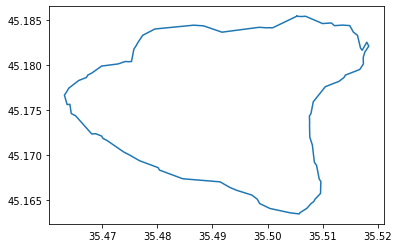

In [31]:
import json
import geojson
from shapely.geometry import shape
# Convert to geojson.geometry.Polygon
with open('Фронтовое.geojson') as f:
    gj = geojson.load(f)

features = gj['features'][0]['geometry']
dam_nominal = shape(features)

# inflate the BBOX 
inflate_bbox = 0 #0.1
minx, miny, maxx, maxy = dam_nominal.bounds

delx = maxx - minx
dely = maxy - miny
minx = minx - delx * inflate_bbox
maxx = maxx + delx * inflate_bbox
miny = miny - dely * inflate_bbox
maxy = maxy + dely * inflate_bbox
    
dam_bbox = BBox([minx, miny, maxx, maxy], crs=CRS.WGS84)


for geom in dam_nominal.geoms:
    plt.plot(*geom.exterior.xy)


### Step 1: Intialize (and implement workflow specific) EOTasks

#### Create an EOPatch and add all EO features (satellite imagery data)

In [32]:
download_task = SentinelHubInputTask(data_collection=DataCollection.SENTINEL2_L1C, 
                                     bands_feature=(FeatureType.DATA, 'BANDS'),
                                     resolution=20, 
                                     maxcc=0.5, 
                                     bands=['B02', 'B03', 'B04', 'B08'], 
                                     additional_data=[(FeatureType.MASK, 'dataMask', 'IS_DATA'), (FeatureType.MASK, 'CLM')],
                                     config=config
                                    )

calculate_ndwi = NormalizedDifferenceIndexTask((FeatureType.DATA, 'BANDS'), (FeatureType.DATA, 'NDWI'), (1, 3))

#### Burn in the nominal water extent

The `VectorToRaster` task expects the vectorised dataset in geopandas dataframe.

In [33]:
dam_gdf = gpd.GeoDataFrame(crs=CRS.WGS84.pyproj_crs(), geometry=[dam_nominal])


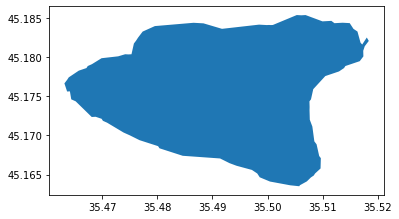

In [34]:
dam_gdf.plot();

In [35]:
add_nominal_water = VectorToRaster(dam_gdf, (FeatureType.MASK_TIMELESS, 'NOMINAL_WATER'), values=1, 
                                   raster_shape=(FeatureType.MASK, 'IS_DATA'), raster_dtype=np.uint8)

#### The cloud mask is already provided by Sentinel Hub, we use it to calulcate the valid data mask. 

Define a `VALID_DATA` layer: pixel has to contain data and should be classified as clear sky by the cloud detector (`CLM` equals 0)

In [36]:
def calculate_valid_data_mask(eopatch):
    is_data_mask = eopatch.mask['IS_DATA'].astype(np.bool)
    cloud_mask = ~eopatch.mask['CLM'].astype(np.bool)
    return np.logical_and(is_data_mask, cloud_mask)

add_valid_mask = AddValidDataMaskTask(predicate=calculate_valid_data_mask)

Calculate fraction of valid pixels per frame and store it as `SCALAR` feature

In [37]:
def calculate_coverage(array):
    return 1.0 - np.count_nonzero(array) / np.size(array)

class AddValidDataCoverage(EOTask):
    
    def execute(self, eopatch):
        
        valid_data = eopatch.get_feature(FeatureType.MASK, 'VALID_DATA')
        time, height, width, channels = valid_data.shape
        
        coverage = np.apply_along_axis(calculate_coverage, 1,
                                       valid_data.reshape((time, height * width * channels)))
        
        eopatch.add_feature(FeatureType.SCALAR, 'COVERAGE', coverage[:, np.newaxis])
        return eopatch
    
add_coverage = AddValidDataCoverage()

Filter out too cloudy scenes. We filter out all observation which have cloud coverage of more than 5%. 


In [38]:
cloud_coverage_threshold = 0.05 

class ValidDataCoveragePredicate:
    
    def __init__(self, threshold):
        self.threshold = threshold
        
    def __call__(self, array):
        return calculate_coverage(array) < self.threshold
    
remove_cloudy_scenes = SimpleFilterTask((FeatureType.MASK, 'VALID_DATA'),
                                        ValidDataCoveragePredicate(cloud_coverage_threshold))

#### Apply Water Detection



In [39]:
class WaterDetector(EOTask):
    
    @staticmethod
    def detect_water(ndwi):
        """
        Very simple water detector based on Otsu thresholding method of NDWI.
        """
        otsu_thr = 1.0
        if len(np.unique(ndwi)) > 1:
            ndwi[np.isnan(ndwi)] = -1
            otsu_thr = threshold_otsu(ndwi)

        return ndwi > otsu_thr

    def execute(self, eopatch):
        water_masks = np.asarray([self.detect_water(ndwi[...,0]) for ndwi in eopatch.data['NDWI']])
        
        # we're only interested in the water within the dam borders
        water_masks = water_masks[...,np.newaxis] * eopatch.mask_timeless['NOMINAL_WATER']
        
        water_levels = np.asarray([np.count_nonzero(mask)/np.count_nonzero(eopatch.mask_timeless['NOMINAL_WATER']) 
                                   for mask in water_masks])
        
        eopatch.add_feature(FeatureType.MASK, 'WATER_MASK', water_masks)
        eopatch.add_feature(FeatureType.SCALAR, 'WATER_LEVEL', water_levels[...,np.newaxis])
        
        return eopatch
    
water_detection = WaterDetector()

### Step 2: Define the EOWorkflow

In [40]:
workflow = LinearWorkflow(download_task, calculate_ndwi, add_nominal_water, add_valid_mask,
                          add_coverage, remove_cloudy_scenes, water_detection)

### Step 3: Run the workflow

Process all Sentinel-2 acquisitions from beginning of 2016 and until beginning of June 2020.

In [41]:
time_interval = ['1992-05-01','2040-06-01']

In [42]:
result = workflow.execute({
    download_task: {
        'bbox': dam_bbox,
        'time_interval': time_interval
    },
})

F:\anaconda\envs\geo\lib\site-packages\eolearn\features\bands_extraction.py:86: RuntimeWarning: invalid value encountered in true_divide
  ndi = (band_a - band_b + self.acorvi_constant) / (band_a + band_b + self.acorvi_constant)


In [43]:
eopatch = list(result.values())[-1]

In [44]:
from skimage.filters import sobel
from skimage.morphology import disk
from skimage.morphology import erosion, dilation, opening, closing, white_tophat

In [45]:
import rasterio
from rasterio import features
import shapely
from shapely.geometry import Point, Polygon

def mask_to_polygons_layer(mask, eopatch, tolerance):
    
    all_polygons = []
    bbox = eopatch.bbox
    size_x = eopatch.meta_info['size_x']
    size_y = eopatch.meta_info['size_y']
    
    vx = bbox.min_x
    vy = bbox.max_y
    cx = (bbox.max_x-bbox.min_x)/size_x
    cy = (bbox.max_y-bbox.min_y)/size_y
    
    for shape, value in features.shapes(mask.astype(np.int16), mask=(mask == 1), transform=rasterio.Affine(cx, 0.0, vx,
       0.0, -cy, vy)): 
        return shapely.geometry.shape(shape).simplify(tolerance, False)
        all_polygons.append(shapely.geometry.shape(shape))
    
    all_polygons = shapely.geometry.MultiPolygon(all_polygons)
    if not all_polygons.is_valid:
        all_polygons = all_polygons.buffer(0)
        # Sometimes buffer() converts a simple Multipolygon to just a Polygon,
        # need to keep it a Multi throughout
        if all_polygons.type == 'Polygon':
            all_polygons = shapely.geometry.MultiPolygon([all_polygons])
    return all_polygons


def toGeoJson (shape):
    return json.dumps(shapely.geometry.mapping(shape))


In [47]:

def plot_rgb_w_water(eopatch, idx):
    ratio = np.abs(eopatch.bbox.max_x - eopatch.bbox.min_x) / np.abs(eopatch.bbox.max_y - eopatch.bbox.min_y)
    fig, ax = plt.subplots(figsize=(ratio * 10, 10))
    
    tolerance = 0.00025
    
    
    
    ax.imshow(2.5*eopatch.data['BANDS'][..., [2, 1, 0]][idx])
    
    observed = eopatch.mask['WATER_MASK'][idx,...,0]
    observed = dilation(observed)
    observed = np.ma.masked_where(observed == False, observed)
    observedShape = mask_to_polygons_layer(observed, eopatch, tolerance)
    
    nominal = eopatch.mask_timeless['NOMINAL_WATER'][...,0]
    nominal = np.ma.masked_where(nominal == False, nominal)
    nominalShape = mask_to_polygons_layer(nominal, eopatch, tolerance)
    
    ax.imshow(observed, cmap=plt.cm.Reds)
    ax.imshow(nominal, cmap=plt.cm.Greens)

POLYGON ((35.47869128169014 45.183691828125, 35.47972863380281 45.183691828125, 35.48050664788732 45.183007359375, 35.48258135211267 45.1831784765625, 35.4856934084507 45.1821517734375, 35.49295487323943 45.181638421875, 35.49632626760563 45.18061171875, 35.49736361971831 45.180953953125, 35.49762295774648 45.18061171875, 35.50021633802817 45.1804406015625, 35.5007350140845 45.1800983671875, 35.50151302816901 45.1804406015625, 35.50280971830986 45.180269484375, 35.50306905633803 45.179585015625, 35.50203170422535 45.1790716640625, 35.50203170422535 45.1785583125, 35.5007350140845 45.1773604921875, 35.5007350140845 45.1766760234375, 35.50151302816901 45.1763337890625, 35.50177236619718 45.174793734375, 35.50151302816901 45.1744515, 35.50203170422535 45.1744515, 35.50306905633803 45.173424796875, 35.50229104225352 45.1730825625, 35.50280971830986 45.1729114453125, 35.50255038028169 45.1722269765625, 35.50306905633803 45.172055859375, 35.50280971830986 45.171371390625, 35.50384707042253 4

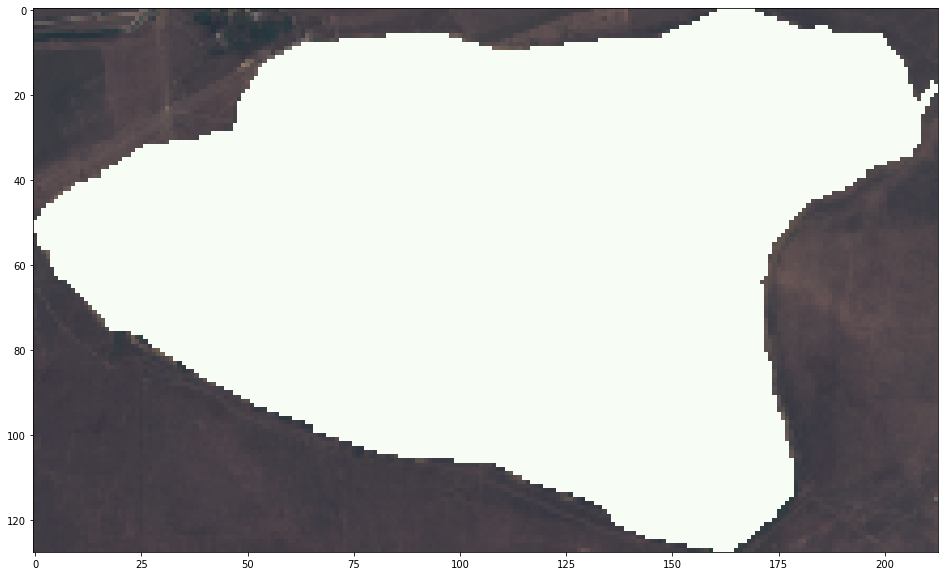

In [48]:
plot_rgb_w_water(eopatch, 0)

POLYGON ((35.47946929577464 45.18334959375, 35.48439671830986 45.1821517734375, 35.48673076056338 45.1811250703125, 35.49062083098591 45.1812961875, 35.49477023943662 45.17992725, 35.49451090140845 45.179585015625, 35.49217685915492 45.179585015625, 35.4924361971831 45.1787294296875, 35.49165818309859 45.178216078125, 35.49191752112676 45.177189375, 35.49139884507042 45.1770182578125, 35.49217685915492 45.1742803828125, 35.49139884507042 45.1735959140625, 35.4924361971831 45.1732536796875, 35.4924361971831 45.1729114453125, 35.49347354929577 45.1730825625, 35.49373288732394 45.1725692109375, 35.49217685915492 45.172740328125, 35.49113950704225 45.17239809375, 35.48880546478873 45.1730825625, 35.4856934084507 45.1730825625, 35.4823220140845 45.171713625, 35.481544 45.1722269765625, 35.47739459154929 45.172055859375, 35.47272650704225 45.1735959140625, 35.47091114084507 45.175478203125, 35.47039246478873 45.1773604921875, 35.47324518309859 45.1785583125, 35.47635723943662 45.179071664062

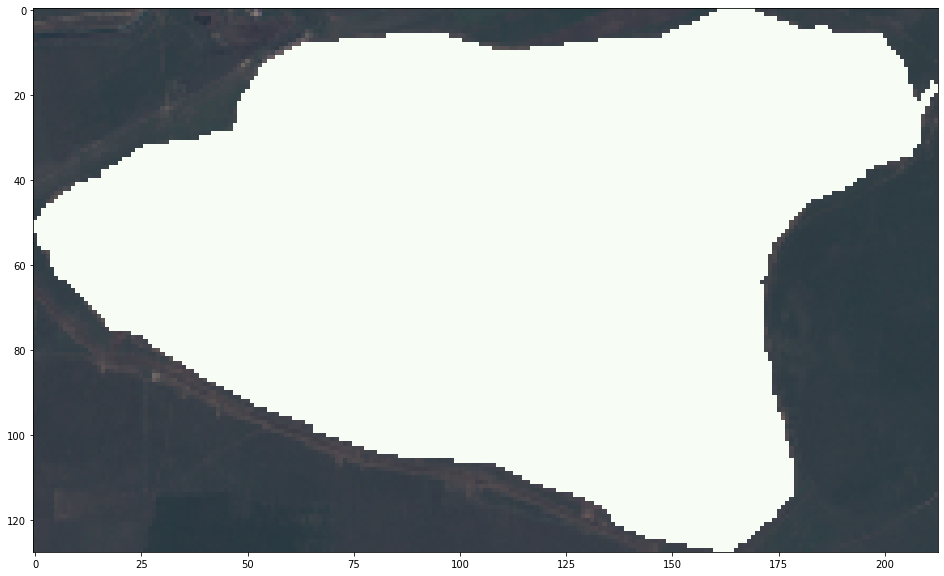

In [49]:
plot_rgb_w_water(eopatch, -5)

In [54]:
def plot_water_levels(eopatch, max_coverage=1.0):
    fig, ax = plt.subplots(figsize=(20,7))

    dates = np.asarray(eopatch.timestamp)
    ax.plot(dates[eopatch.scalar['COVERAGE'][...,0]<max_coverage],
            eopatch.scalar['WATER_LEVEL'][eopatch.scalar['COVERAGE'][...,0]<max_coverage],
            'bo-',alpha=0.7, label='Water Level')
    ax.plot(dates[eopatch.scalar['COVERAGE'][...,0]<max_coverage],
            eopatch.scalar['COVERAGE'][eopatch.scalar['COVERAGE'][...,0]<max_coverage],
            '--',color='gray',alpha=0.7, label='Cloud Coverage')
    ax.set_ylim(0.0,1.1)
    ax.set_xlabel('Date')
    ax.set_ylabel('Water Level')
    ax.set_title('Detected Water Level')
    ax.grid(axis='y')
    ax.legend(loc='best')
    return ax

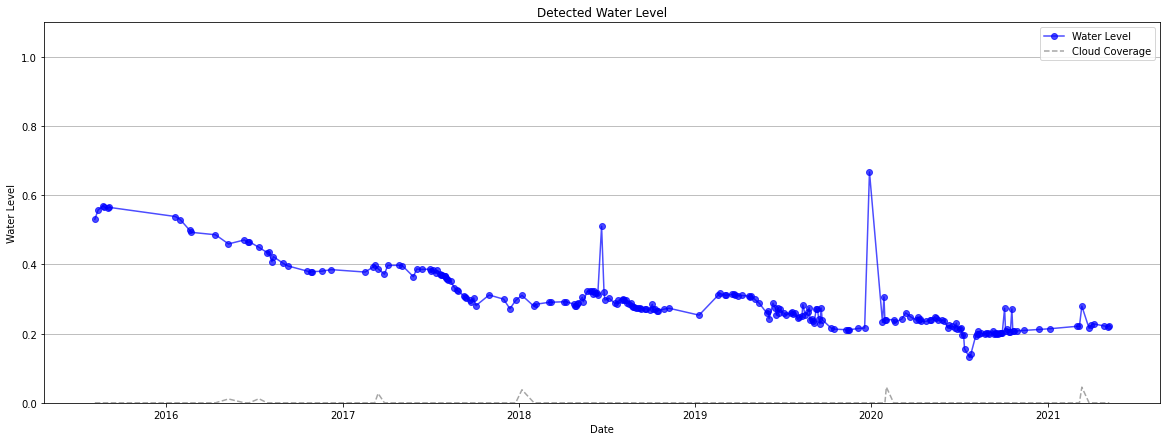

In [55]:
ax = plot_water_levels(eopatch, 1.0);

In [61]:
eopatch

EOPatch(
  data: {
    BANDS: numpy.ndarray(shape=(248, 128, 213, 4), dtype=float32)
    NDWI: numpy.ndarray(shape=(248, 128, 213, 1), dtype=float32)
  }
  mask: {
    CLM: numpy.ndarray(shape=(248, 128, 213, 1), dtype=uint8)
    IS_DATA: numpy.ndarray(shape=(248, 128, 213, 1), dtype=bool)
    VALID_DATA: numpy.ndarray(shape=(248, 128, 213, 1), dtype=bool)
    WATER_MASK: numpy.ndarray(shape=(248, 128, 213, 1), dtype=uint8)
  }
  scalar: {
    COVERAGE: numpy.ndarray(shape=(248, 1), dtype=float64)
    WATER_LEVEL: numpy.ndarray(shape=(248, 1), dtype=float64)
  }
  label: {}
  vector: {}
  data_timeless: {}
  mask_timeless: {
    NOMINAL_WATER: numpy.ndarray(shape=(128, 213, 1), dtype=uint8)
  }
  scalar_timeless: {}
  label_timeless: {}
  vector_timeless: {}
  meta_info: {
    maxcc: 0.5
    size_x: 213
    size_y: 128
    time_difference: datetime.timedelta(0, 1)
    time_interval: (datetime.datetime(1992, 5, 1, 0, 0), datetime.datetime(2040, 6, 1, 23, 59, 59))
  }
  bbox: BBox(((35.4

In [68]:
from eolearn.core import OverwritePermission

eopatch.save('./example_patch', overwrite_permission=OverwritePermission.OVERWRITE_FEATURES)